In [1]:
import pandas as pd
pd.set_option("display.max_rows", 150)
pd.set_option('display.max_colwidth', -1)


import numpy as np

import glob

import gpxpy
import gpxpy.gpx

import re

from IPython.display import SVG,display, HTML

import requests
import pickle

from sklearn.neighbors import KDTree

import seaborn as sns

In [2]:
# functions for judging a description
not_flowing_keywords = ["dry", "no water", "no flow"]
def isNotFlowing(description):
    return any([kw in description for kw in not_flowing_keywords])
assert(isNotFlowing("looks dry"))

flowing_keywords = ["good", "flowing", "flow", "lots", "working", "liter", "gallon", "g/s", "l/s", "plenty"]
def isFlowing(description):
    return any([kw in description for kw in flowing_keywords])
assert(isFlowing("flowing well"))


tank_keywords = ["tank", "cache"]
def isTank(description):
    return any([kw in description for kw in tank_keywords])
assert(isTank("tank empty"))

In [3]:
# a function that tries to fix a location id, leaves non-waypoint labels alone in case they are in the gps data
# fixes the leading zeros problem WR004 = WR0004
def clean_loc_id(id):
    try:
        waypoint_search = re.search('((?:WR|WA)(?:CS|))([0-9]+)', id, re.IGNORECASE)

        if waypoint_search:        
            waypoint_type = waypoint_search.group(1)
            waypoint_num = waypoint_search.group(2)

            return f"{waypoint_type}{int(waypoint_num):04}"
    except:
        return id
    return id
assert(clean_loc_id("WR004") == "WR0004")

In [240]:
# functions for finding the last positive result and last negative result
def last_pos(mile, date):
    last_pos_date = data[(data.mile == mile) & (data.status==1) & (data.date < date)].date.max()
    if type(last_pos_date) == float:
        return 2000
    if pd.isnull(last_pos_date):
        return 2000
    return (date - last_pos_date).days
    
def last_neg(mile, date):
    last_neg_date = data[(data.mile == mile) & (data.status==0) & (data.date < date)].date.max()    
    if type(last_neg_date) == float:
        return 2000
    if pd.isnull(last_neg_date):
        return 2000
    return (date - last_neg_date).days

In [5]:
# create a lat, lon, and name dictionaries keyed on loc_ids 
waypoints = []
for path in glob.glob("gps/*.gpx"):
    gpx_file = open(path, 'r')
    gpx = gpxpy.parse(gpx_file)
    waypoints += (gpx.waypoints)
    
lat = {clean_loc_id(wp.name):wp.latitude for wp in waypoints}
lon = {clean_loc_id(wp.name):wp.longitude for wp in waypoints}

In [6]:
# a generator for sequentially reading in the data
def data_generator():
    for f in glob.glob("pct_data/*.xlsx"):
        data = pd.read_excel(f).dropna()
        _,cols = data.shape
        if cols == 7:
            data.columns = ["map","mile","loc_id","name", "description", "date", "user"]
        if cols == 8:
            data.columns = ["map","mile_2","mile","loc_id","name", "description", "date", "user"]
        yield data

In [27]:
# import and combine tip line data
data_tip = pd.concat(data_generator())

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [26]:
# read in guthook data
data_gh=pd.read_csv("guthook_data/PCTWater-wpts-Comments.csv").rename(columns=
    {
        "Date":"date",
        "WptId":"loc_id",
        "WptName":"name",
        "Latitude":"lat",
        "Longitude":"lon",
        "Comment":"description",
        "PCT Mile": "mile"
    })

In [56]:
# clean up the guthook dates
data_gh.date = pd.to_datetime(data_gh.date)
data_tip.date = pd.to_datetime(data_tip.date, errors="coerce")

In [57]:
# clean up the lod_ids in the tip line data
data_tip.loc_id = data_tip.loc_id.apply(clean_loc_id)

In [58]:
# create lat and lon columns
data_tip["lat"] = data_tip["loc_id"].map(lat)
data_tip["lon"] = data_tip["loc_id"].map(lon)

In [59]:
# merge the two mile fields in the tip lin data
data_tip.mile = data_tip.mile.fillna(data_tip.mile_2)

In [60]:
# drop data with missing coordinates
data_tip = data_tip.dropna(subset=["lat", "mile"])

In [61]:
# combine report and guthook
data = pd.concat([data_tip, data_gh])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [62]:
# clean up the descriptions
data.description = data.description.str.split("\n").str[0].str.lower()

In [63]:
# create a unix time column
data["unix_time"] = (pd.to_datetime(data["date"], errors='coerce').astype(np.int64)//1000000000)

In [64]:
# create not_flowing and flowing columns
data["not_flowing"] = data["description"].map(isNotFlowing, na_action="ignore")
data["flowing"] = data["description"].map(isFlowing, na_action="ignore")
data["tank"] = data["description"].map(isTank, na_action="ignore")
data["decision"] = (data.flowing^data.not_flowing)&(~data.tank.astype(bool)) # logical xor
data["status"] = data.flowing.astype(float)

In [65]:
# calculate how much data do I lose after classification
print(f"only one {(data.flowing^data.not_flowing).sum()}")
print(f"at least one {(data.flowing|data.not_flowing).sum()}")
print(f"both {(data.flowing&data.not_flowing).sum()}")
print(f"tank {data.tank.sum()}")


only one 44678
at least one 45796
both 1118
tank 1694


In [66]:
# remove all data with no decision
data = data[data.decision]

In [67]:
# remove duplicate entries (ones with the same date and loc_id)
data = data.drop_duplicates(subset=["date","mile"])

In [69]:
# calculate the day of year features
data['month'] = data.date.map(lambda d:d.month)
data['DOY'] = data.date.dt.dayofyear
data['sinDOY'] = np.sin(2  * np.pi * data.date.dt.dayofyear/365.)
data['cosDOY'] = np.cos(2  * np.pi * data.date.dt.dayofyear/365.)

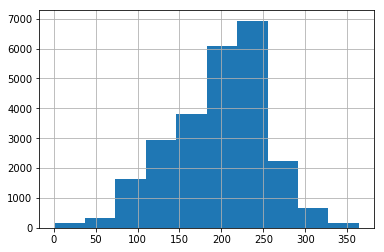

In [70]:
# what does the day of year feature look like?
data.DOY.hist()

In [71]:
# pick which miles we'll focus on
miles = list(data.groupby("mile").nunique().sort_values(by="date")[-150:].loc_id.index)

In [72]:
# remove other data
data = data[data.mile.isin(miles)]

In [73]:
data.shape

(8677, 21)

In [75]:
# create last positive and negative result columns
data["last_pos"] = data.apply(lambda row: last_pos(row.mile, row.date), axis=1)
data["last_neg"] = data.apply(lambda row: last_neg(row.mile, row.date), axis=1)


In [76]:
data["last_pos_inv"] = 1./ (data["last_pos"]+1)
data["last_neg_inv"] = 1./ (data["last_neg"]+1)


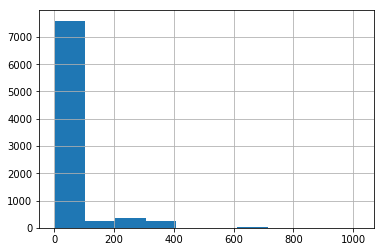

In [77]:
# what does this data look like
data.last_pos.hist()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


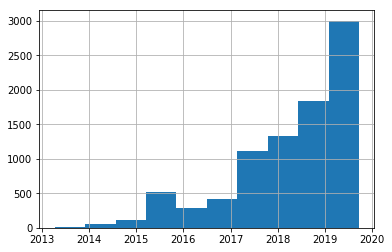

In [86]:
# when does my data come from?
data.date.hist()

In [87]:
# function for 
try:
    f = open('rain_memo_coords.pkl', 'rb')
    rain_memo = pickle.load(f)
    f.close()
except:
    print("no rain memo")
    rain_memo = {}

def getRainfall(lat, lon, unix_time):
    lat, lon = round(lat,2),round(lon,2)
    if (lat, lon, unix_time) in rain_memo:
        return rain_memo[(lat,lon, unix_time)]
    print(f"{lat},{lon},{unix_time} not found, calling DarkSky")
    r = requests.get(f"https://api.darksky.net/forecast/b2edaf747348d39d0c0f060a4a8497a2/{lat},{lon},{unix_time}?exclude=currently,minutely,hourly,alerts")
    
    try:
        rain = r.json()["daily"]["data"][0]["precipIntensity"]
        rain_memo[(lat, lon, unix_time)] = rain
    except:
        rain = 0
        print(f"Data parse error {lat},{lon},{unix_time}")
        
    f = open('rain_memo_coords.pkl', 'wb')
    pickle.dump(rain_memo, f)
    f.close() 
    
    return rain

In [88]:
# function for calculating cumulative rain totals
def getRainSum(lat, lon, unix_time, n):
    return 24 * sum([getRainfall(lat, lon, unix_time - (24*60*60*day)) for day in range(0,n)])

In [184]:
# calculate cumulative rain fields
data["rain_5"] = data.apply(lambda row: getRainSum(row.lat, row.lon, row.unix_time, 5), axis=1)
data["rain_3"] = data.apply(lambda row: getRainSum(row.lat, row.lon, row.unix_time, 3), axis=1)

43.52,-122.13,1437004800 not found, calling DarkSky
Data parse error 43.52,-122.13,1437004800
43.52,-122.13,1436918400 not found, calling DarkSky
Data parse error 43.52,-122.13,1436918400
43.52,-122.13,1436832000 not found, calling DarkSky
Data parse error 43.52,-122.13,1436832000
43.52,-122.13,1436745600 not found, calling DarkSky
Data parse error 43.52,-122.13,1436745600
43.52,-122.13,1436659200 not found, calling DarkSky
Data parse error 43.52,-122.13,1436659200
43.52,-122.13,1437696000 not found, calling DarkSky
Data parse error 43.52,-122.13,1437696000
43.52,-122.13,1437609600 not found, calling DarkSky
Data parse error 43.52,-122.13,1437609600
43.52,-122.13,1437523200 not found, calling DarkSky
Data parse error 43.52,-122.13,1437523200
43.52,-122.13,1437436800 not found, calling DarkSky
Data parse error 43.52,-122.13,1437436800
43.52,-122.13,1437350400 not found, calling DarkSky
Data parse error 43.52,-122.13,1437350400
43.52,-122.13,1438732800 not found, calling DarkSky
Data par

In [91]:
data[data.status==0].rain_5_rel.mean()

0.2363282051282051

In [ ]:
data[data.status==1].rain_5_rel.mean()

In [92]:

data[data.status==1].groupby("mile").rain_5_rel.mean().hist(bins=np.arange(0,2,.1), alpha=0.5)

ax = data[data.status==0].groupby("mile").rain_5_rel.mean().hist(bins=np.arange(0,2,.1), alpha=0.5)

ax.set_ylabel("count", fontsize=20)
ax.set_xlabel("5 day rainfall relative to source average", fontsize=20)

AttributeError: 'DataFrameGroupBy' object has no attribute 'rain_5_rel'

In [93]:

data[data.status==1].groupby("mile").ground_water.mean().hist(bins=np.arange(0,500,20), alpha=0.5)

data[data.status==0].groupby("mile").ground_water.mean().hist(bins=np.arange(0,500,20), alpha=0.5)

AttributeError: 'DataFrameGroupBy' object has no attribute 'ground_water'

In [208]:
gw = pd.read_csv("ground_water/gwlevels", sep="\t")

In [209]:
def dms2lat(dms):
    dms = str(dms)
    degrees, minutes, seconds = dms[0:2], dms[2:4], dms[4:6]
    #print(degrees)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    return dd;

def dms2lon(dms):
    dms = str(dms)
    degrees, minutes, seconds = dms[6:9], dms[9:11], dms[11:13]
    #print(degrees)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    return -dd;

In [210]:
gw["lat"] = gw.site_no.map(dms2lat)
gw["lon"] = gw.site_no.map(dms2lon)

In [211]:
gw = gw[['lev_va', 'lev_dt', 'lat', 'lon', 'site_no']]
gw.columns=["meas", "date", "lat", "lon", 'site_id']

In [212]:
gw["unix_time"] = (pd.to_datetime(gw["date"], errors='coerce').astype(int)//1000000000)
gw["unix_time_reduced"] = gw["unix_time"]//10000000
data["unix_time_reduced"] = gw["unix_time"]//10000000
gw = gw.dropna()

In [213]:
kdt = KDTree(gw[['lat', 'lon', 'unix_time_reduced']])
dist, i = kdt.query(data[['lat', 'lon', 'unix_time_reduced']])

In [214]:
data['ground_water'] = gw.iloc[i.flatten()].meas.values

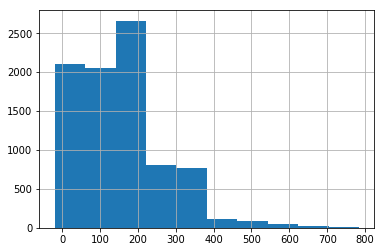

In [101]:
data.ground_water.hist()

In [102]:
def last_result(row):
    try:
        return data[(data.mile==row.mile)&(data.date < row.date)].sort_values("date", ascending=False).status.values[0]
    except:
        return 0

In [103]:
data["last_result"] = data.apply(last_result, axis=1)

In [302]:
import datetime



date_before = datetime.datetime(2019, 7, 1)

#min_max_scaler = MinMaxScaler()
#inputs = min_max_scaler.fit_transform(inputs)


train = data[data.date < date_before]

train_neg_over = train[train.status == 0].sample(train[train.status == 1].shape[0], replace=True)
train = pd.concat([train[train.status == 1], train_neg_over], axis=0)

test = data[data.date >= date_before]


test_neg_over = test[test.status == 0].sample(test[test.status == 1].shape[0], replace=True)
test = pd.concat([test[test.status == 1], test_neg_over], axis=0)

print(train.shape,  test.shape)

(13320, 31) (2864, 31)


In [303]:
rain_5_avg_source = train.groupby("mile").rain_5.mean()


data["rain_5_avg"] = data.mile.map(lambda m: rain_5_avg_source.get(m))

train["rain_5_avg"] = train.mile.map(lambda m: rain_5_avg_source.get(m))
train["rain_5_rel"] = train.rain_5 / train.rain_5_avg

test["rain_5_avg"] = test.mile.map(lambda m: rain_5_avg_source.get(m))
test["rain_5_rel"] = test.rain_5 / test.rain_5_avg

In [304]:
rain_3_avg_source = train.groupby("mile").rain_3.mean()
train["rain_3_avg"] = train.mile.map(lambda m: rain_3_avg_source.get(m))
train["rain_3_rel"] = train.rain_3/ train.rain_3_avg

test["rain_3_avg"] = test.mile.map(lambda m: rain_3_avg_source.get(m))
test["rain_3_rel"] = test.rain_3/ test.rain_3_avg

In [305]:
# calculate last results normalized by overall measurement frequency per source
last_avg_source = data.groupby("mile")["last_result"].mean()

train["last_avg"] = train.mile.map(lambda m: last_avg_source.get(m))
train["last_neg_rel"] = train.last_neg / train.last_avg
train["last_pos_rel"] = train.last_pos / train.last_avg


test["last_avg"] = test.mile.map(lambda m: last_avg_source.get(m))
test["last_neg_rel"] = test.last_neg / test.last_avg
test["last_pos_rel"] = test.last_pos / test.last_avg



In [306]:
# calculate last results normalized by overall measurement frequency per source
prob_source = data.groupby("mile")["status"].mean()


train["prob_exp"] = train.mile.map(lambda m: prob_source.get(m))
test["prob_exp"] = test.mile.map(lambda m: prob_source.get(m))

In [307]:
# choose the features we'll use
features = ["rain_5_rel","last_pos","last_neg","prob_exp", "sinDOY", "cosDOY","ground_water"]


In [308]:
# import some packages for modeling
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, BayesianRidge
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_validate, GroupKFold, KFold, StratifiedKFold, cross_val_score, GridSearchCV

import copy

from graphviz import Source

import time

from matplotlib import cm
from scipy import interpolate

import matplotlib.pyplot as plt

Train size 8357
Test size 1974


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

tree
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89      1271
         1.0       0.79      0.82      0.81       703

    accuracy                           0.86      1974
   macro avg       0.85      0.85      0.85      1974
weighted avg       0.86      0.86      0.86      1974

dummy
              precision    recall  f1-score   support

         0.0       0.65      0.64      0.64      1271
         1.0       0.36      0.36      0.36       703

    accuracy                           0.54      1974
   macro avg       0.50      0.50      0.50      1974
weighted avg       0.54      0.54      0.54      1974

most frequent
              precision    recall  f1-score   support

         0.0       0.63      0.61      0.62      1271
         1.0       0.33      0.35      0.34       703

    accuracy                           0.52      1974
   macro avg       0.48      0.48      0.48      1974
weighted avg       0.52      0.52      0.52      

Text(0,0.5,'Precision')

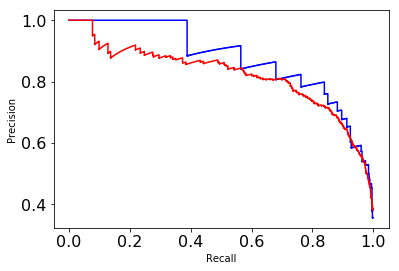

In [309]:
# build the test and training sets
train = train[features+["status"]].dropna()
test = test[features+["status"]].dropna()

print(f"Train size {train.shape[0]}")
print(f"Test size {test.shape[0]}")

X_train = train[features]
y_train = train.status
X_test = test[features]
y_test = test.status

# normalize the data
X_train=(X_train-X_train.mean())/X_train.std()
X_test=(X_test-X_test.mean())/X_test.std()


# initialize a logistic regressor
model = LogisticRegression().fit(X_train, y_train)

# initialize a grid search and fit
clf = GridSearchCV(model, {'C':[1, 10]}, scoring='roc_auc', cv=5).fit(X_train, y_train)
                        
# tested model graveyard
#model = SVC(probability=True).fit(X_train, y_train)
#br = BayesianRidge().fit(X_train, y_train)
#model = RandomForestClassifier(max_depth = 5).fit(X_train, y_train)
#model = AdaBoostClassifier(learning_rate=0.25,n_estimators=50).fit(X_train, y_train)
#model = GradientBoostingClassifier().fit(X_train, y_train)
#model = DecisionTreeClassifier(max_depth = 7, criterion='entropy').fit(X_train, y_train)

# initialize some dummy classifiers
model = clf
dummy = DummyClassifier().fit(X_train, y_train)
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

# test the modls
print('tree')
print(classification_report(y_test, model.predict(X_test)))
#print(y_test[model_cal.predict(X_test)].mean())

print('dummy')
print(classification_report(y_test, dummy.predict(X_test)))

print('most frequent')
print(classification_report(y_test, dummy.predict(X_test)))


#print('last')
#print(classification_report(y_test, X_test.last_result))


# calculate precision recall curves
precision, recall, thresh = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
plt.step(recall, precision, color='b', alpha=1, where='post')


precision, recall, thresh = precision_recall_curve(y_train, model.predict_proba(X_train)[:,1])
plt.step(recall, precision, color='r', alpha=1, where='post')

# use precision recall curves to determine the appropriate thresholds
thresh_95 = min([t for (p, t) in zip(precision, thresh) if p > 0.9])
thresh_50 = min([t for (p, t) in zip(precision, thresh) if p > 0.6])
print(thresh_95)
print(thresh_50)

# print classification reports based on thresholds
print('95')
print(classification_report(y_train, model.predict_proba(X_train)[:, 1] > thresh_95))

print('50')
print(classification_report(y_train, model.predict_proba(X_train)[:, 1] > thresh_50))
#print(y_test[model_cal.predict_proba(X_test)[:, 1] > 0.8].mean())


print('95')
print(classification_report(y_test, model.predict_proba(X_test)[:, 1] > thresh_95))

print('50')
print(classification_report(y_test, model.predict_proba(X_test)[:, 1] > thresh_50))
#print(y_test[model_cal.predict_proba(X_test)[:, 1] > 0.8].mean())




plt.xlabel('Recall')
plt.ylabel('Precision')

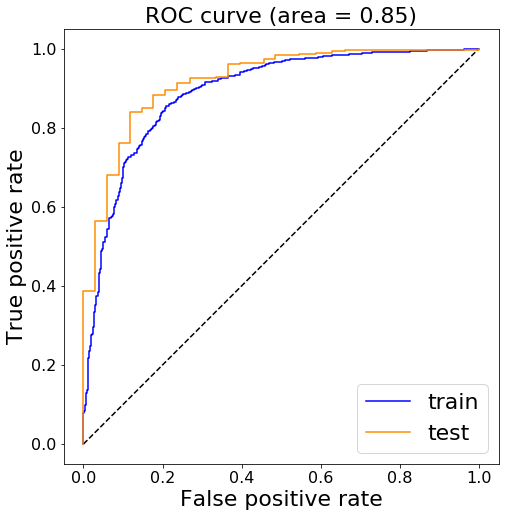

In [310]:
# plot the ros curves for the train and test sets
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111)

ax.plot([0, 1], [0, 1], 'k--')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 

y_probs = model.predict_proba(X_train)[:, 1]
y_predicted = model.predict(X_train)
auc = roc_auc_score(y_train, y_predicted)
false_positive, true_positive, _  = roc_curve(y_train, y_probs)
ax.plot(false_positive, true_positive, color='blue', label='train')


ax.set_aspect(aspect=1)
y_probs = model.predict_proba(X_test)[:, 1]
y_predicted = model.predict(X_test)
auc = roc_auc_score(y_test, y_predicted)
false_positive, true_positive, _  = roc_curve(y_test, y_probs)
ax.plot(false_positive, true_positive, color='darkorange', label='test')
ax.legend(fontsize=22)


plt.xlabel('False positive rate', fontsize=22)
plt.ylabel('True positive rate', fontsize=22)
plt.title('ROC curve (area = %0.2f)' % auc, fontsize=22)
plt.show()

[ 0.45585505  0.83182018 -0.84894206  1.11243762  0.69339299 -0.23330678
  0.02139893]


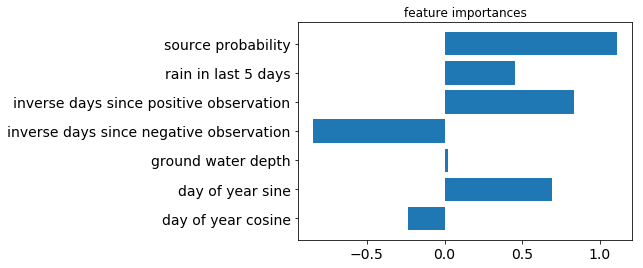

In [311]:
# plot feature importances
imp =model.get_params()['estimator'].coef_[0]

names = {
    'cosDOY': 'day of year cosine',
    'sinDOY': 'day of year sine',
    'rain_5_rel': 'rain in last 5 days',
    'prob_exp': 'source probability',
    'last_pos': 'days since positive observation',
    'last_pos_inv': 'inverse days since positive observation',
    'last_neg': 'days since negative observation',
    'last_neg_inv': 'inverse days since negative observation',
    'ground_water': 'ground water depth'
}

print(imp)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title("feature importances")
ax.barh([names[feat] for feat in X_test.columns], imp)
#ax.set_xticklabels( ["cosine day of year", "ground water depth", "last negative observation","last positive observation",  "source probability", "rain in last 3 days",  "rain in last 5 days", "sine day of year)"], rotation=45 , ha="right")
plt.show()


Text(0,0.5,'count')

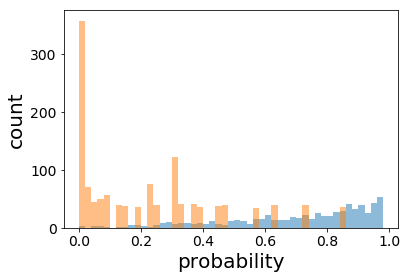

In [312]:
# plot class histograms for training set
#plt.hist(model_cal.predict_proba(X_test)[:,1], bins=np.arange(0,1,.1))
plt.hist(model.predict_proba(X_test)[:,1][y_test.astype(bool).values], bins=np.arange(0,1,.02), alpha = 0.5)
plt.hist(model.predict_proba(X_test)[:,1][~(y_test.astype(bool).values)], bins=np.arange(0,1,.02),alpha = 0.5)
plt.xlabel("probability", fontsize=20)
plt.ylabel("count", fontsize=20)

Text(0,0.5,'count')

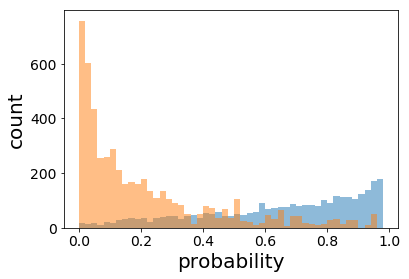

In [313]:
# plot class histograms for test set
#plt.hist(model_cal.predict_proba(X_valid)[:,1], bins=np.arange(0,1,.1))
plt.hist(model.predict_proba(X_train)[:,1][y_train.astype(bool).values], bins=np.arange(0,1,.02), alpha = 0.5)
plt.hist(model.predict_proba(X_train)[:,1][~(y_train.astype(bool).values)], bins=np.arange(0,1,.02),alpha = 0.5)
plt.xlabel("probability", fontsize=20)
plt.ylabel("count", fontsize=20)

In [314]:
# export data
out = []

X_train=(X_train-X_train.mean())/X_train.std()

for mile in miles:
    now = pd.Timestamp.now().round('1d') 
    lat = data[data.mile==mile].lat.values[0]
    lon = data[data.mile==mile].lon.values[0]
    #rain_3_avg = data[data.mile==mile].rain_3_avg.values[0]
    rain_5_avg = data[data.mile==mile].rain_5_avg.values[0]
    #last_avg = data[data.mile==mile].last_avg.values[0]
    name = data[data.mile==mile].name.mode().values[0]
    last_3 = data[data.mile == mile].sort_values(by="date", ascending=False).tail(3)[["date", "status"]].to_dict(orient="record")
    
    
    result = {
        'lat': lat, 
        'lon': lon, 
        'name': name,
        'mile': mile,
        'last_3': last_3
    }
    
    _, i = kdt.query([[lat, lon, (now.value // 10**16) ]])
    ground_water = gw.iloc[i.flatten()].meas.values[0]
    
    
    for days in range(4):
        prediction = model.predict_proba([[
                    (getRainSum(lat, lon, int(now.value/10**9) + (24*60*60*days), 5)/rain_5_avg - X_train.rain_5_rel.mean()) / X_train.rain_5_rel.std(), 
                    ((last_pos(mile, now) + days)- X_train.last_pos.mean()) / X_train.last_pos.std(),
                    ((last_neg(mile, now) + days) - X_train.last_neg.mean()) / X_train.last_neg.std(),
                    (data[mile == data.mile].status.mean()- X_train.prob_exp.mean()) / X_train.prob_exp.std(),
                    (np.sin(2  * np.pi * now.dayofyear/365.)- X_train.sinDOY.mean()) / X_train.sinDOY.std(),
                    (np.cos(2  * np.pi * now.dayofyear/365.)- X_train.cosDOY.mean()) / X_train.cosDOY.std(),
                    (ground_water- X_train.ground_water.mean()) / X_train.ground_water.std()
                ]])
        result[f'prediction_{days}'] = prediction[0][1]
    
    out.append(result)

    
f = open('out_combined.pkl', 'wb')
pickle.dump(out, f)
f.close() 

In [1760]:
data[data.prob_exp < .90].groupby("mile").count().sort_values(by="date", ascending=False).head(20).index.values

array([  105. ,    15.4,   680.8,    32. ,    68.4,    24.1,   285.9,
         112.6,   693.5,     6.6,   425.8,   315.8,   136.5,   719. ,
         193.8,  1200.7,   607.1,  1965.7,     2.7,   510.9])

Text(0.5,0,'year')

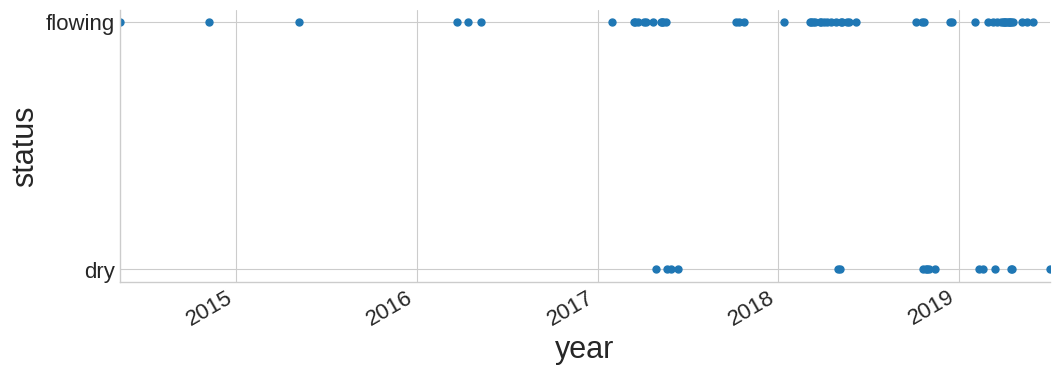

In [1763]:
ax = data[data.mile== 68.4].plot(x="date", y="status", style=".", figsize=(12,4), legend=False,markersize=10)
#display(data[data.mile==668.7])
ax.set_yticks([0, 1]);
ax.set_yticklabels([ "dry","flowing"]);
ax.tick_params(axis='both', which='major', labelsize=16)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

plt.ylabel("status", fontsize=22) 
plt.xlabel("year", fontsize=22) 

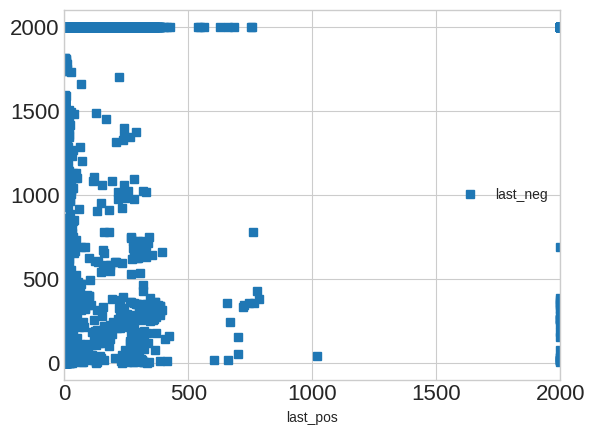

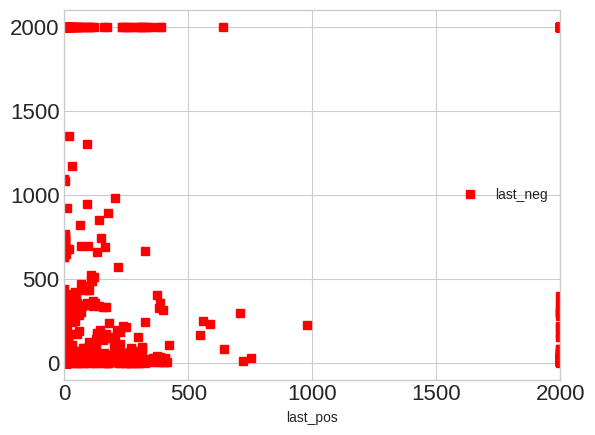

In [1904]:
data[data.status==1].plot(x="last_pos", y="last_neg", style="s")
data[data.status==0].plot(x="last_pos", y="last_neg", style="sr")

NameError: name 'variables' is not defined

In [1278]:
train = train[["rain_5_rel","last_pos_rel","last_neg_rel", "prob_exp", "sinDOY", "cosDOY", "status"]].dropna()
test = test[["rain_5_rel","last_pos_rel","last_neg_rel", "prob_exp", "sinDOY", "cosDOY", "status"]].dropna()

print(f"Train size {train.shape[0]}")
print(f"Test size {test.shape[0]}")

X_train = train[["rain_5_rel","last_pos_rel","last_neg_rel", "prob_exp", "sinDOY", "cosDOY"]]
y_train = train.status
X_test = test[["rain_5_rel","last_pos_rel","last_neg_rel", "prob_exp", "sinDOY", "cosDOY"]]
y_test = test.status


#dt = LogisticRegression(penalty="elasticnet").fit(X_train, y_train)
#dt = SVC(probability=True).fit(X_train, y_train)
#br = BayesianRidge().fit(X_train, y_train)
#dt = RandomForestClassifier(max_depth = 5).fit(X_train, y_train)
dt = AdaBoostClassifier(n_estimators = 100).fit(X_train, y_train)
#dt = DecisionTreeClassifier(max_depth = 7, criterion='entropy').fit(X_train, y_train)

dummy = DummyClassifier().fit(X_train, y_train)
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

dt_cal = CalibratedClassifierCV(dt, cv='prefit').fit(X_train, y_train)
dummy_cal = CalibratedClassifierCV(dummy, cv='prefit').fit(X_train, y_train)
dummy_majority_cal = CalibratedClassifierCV(dummy_majority, cv='prefit').fit(X_train, y_train)


classifiers = []
reports = []
cv = StratifiedKFold(n_splits=5, random_state=0)
for train_index, test_index in cv.split(X_train, y=y_train):
    xt, xv, yt, yv = X_train.iloc[train_index], X_train.iloc[test_index], y_train.iloc[train_index], y_train.iloc[test_index]
    dt.fit(xt, yt)
    classifiers.append(copy.copy(dt))
    reports.append(classification_report(yv, dt.predict(xv), output_dict=True))

dt.fit(X_test, y_test)
classifiers.append(copy.copy(dt))
reports.append(classification_report(y_test, dt.predict(X_test), output_dict=True))


#print('last')
#print(classification_report(y_valid, X_valid.last_result))

precision, recall, thresh = precision_recall_curve(y_valid, dt.predict_proba(X_valid)[:,1])

thresh_95 = min([t for (p, t) in zip(precision, thresh) if p > 0.95])
thresh_50 = min([t for (p, t) in zip(precision, thresh) if p > 0.5])
print(thresh_95)
print(thresh_50)

for p, t in zip(precision, thresh):
    if p > 0.5:
        print (p,t)
        break


plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])

KeyError: "['last_pos_rel', 'last_neg_rel'] not in index"

In [1657]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, SpectralClustering

In [1661]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = data_over.description
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)


In [1662]:
true_k = 2
model = KMeans(n_clusters=true_k)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [1663]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [1664]:
for i in range(true_k):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]}")

Cluster 0:
dry
flowing
flow
water
good
well
of
and
still
15
Cluster 1:
the
water
to
is
and
of
dry
you
but
trail


In [1669]:
print(data.description.head(10))
X = vectorizer.transform(data.description.head(10))
predicted = model.predict(X)
print(predicted)

10    flowing pretty good.                                                                                                                                                                                                     
13    dry                                                                                                                                                                                                                      
17    dry                                                                                                                                                                                                                      
18    2/3/18 (warner springs monty) : flowing. crossed on a log.                                                                                                                                                               
27    2/3/18 (warner springs monty) : dry.                                                              